### **Problem Description**
In the homework you will have fun to find the best parameter of the classification algorithm using a simple holdout validation and 3-fold cross validation of an in-house classification algorithm. We are using the C&RT tree. We generate 2000 data with 1 or -1 classification problem and split the first 1002 as training data and the rest as testing data.

In [ ]:
import numpy as np
from scipy import stats
import sys
class TreeNode():
    def __init__(self):
        self.left = None
        self.right = None
        self.theta = None
        self.dimension = None
        self.is_branch = False
        self.tree_depth = 0

    def branch_stump(self, theta, dimension):
        self.left = TreeNode()
        self.right = TreeNode()
        self.theta = theta
        self.dimension = dimension
        self.is_branch = True
        return self.left, self.right

    def save_label(self, class_pred):
        self.prediction = class_pred

    def show(self, indent=0):
        if(self.is_branch == True):
            print("Tree theta is %f and dimension is %f" %(self.theta, self.dimension))
            print("---" * indent)
            self.left.show(indent=indent+1)
            self.right.show(indent=indent+1)

In [ ]:
class CRTree():

    def __init__(self, tree_depth):
        self.root = TreeNode()
        self.tree_depth = tree_depth

    def train(self, data, y):
        self.branch(data, self.root, y)

    def showTree(self):
        self.root.show()

    def branch(self, data, node, y):

        # check if stop branching 
        if(np.unique(y).shape[0] == 1 or np.unique(data).shape[0] == 1 or node.tree_depth == self.tree_depth):
            node.save_label(stats.mode(y)[0][0])
            return

        # calculate the spliting dimenstion and theta
        theta, dimension  = self.cal_branch(data, y)

        # split the data
        data_right = data[np.where(data[:, dimension] >= theta)]
        y_right = y[np.where(data[:, dimension] >= theta)]
        data_left = data[np.where(data[:, dimension] < theta)]
        y_left = y[np.where(data[:, dimension] < theta)]
                          
        # recorde in the node
        left_node, right_node = node.branch_stump(theta, dimension)
        left_node.tree_depth = node.tree_depth+1
        right_node.tree_depth = node.tree_depth+1
        self.branch(data_right, right_node, y_right)
        self.branch(data_left, left_node, y_left)

        return    

    def cal_branch(self, data, y):

        # store the best impuraty, theta, dimension
        best_impuraty = sys.float_info.max
        best_theta = None
        best_dimension = None

        # iterate over the feature dimension
        for d in range(data.shape[1]):
          feature_array = data[:, d]
          unique_feature = np.unique(feature_array)

          # iterate the segment
          for segment in range(unique_feature.shape[0]-1):
            theta = (unique_feature[segment] + unique_feature[segment+1])/2
            b_score = self.cal_score(data, d, theta, y)
            if(b_score < best_impuraty):
                best_impuraty = b_score
                best_theta = theta
                best_dimension = d

        return best_theta, best_dimension

    def cal_score(self, data, dimension, theta, y):
        # calculate the impuraty over left and right
        split_left = np.where(data[:, dimension] >= theta)[0]
        split_right = np.where(data[:, dimension] < theta)[0]
        return (split_left.shape[0])*self.cal_impuraty(data, y, split_left) + (split_right.shape[0])*self.cal_impuraty(data, y, split_right)

    def cal_impuraty(self, data, y, index):
        # calculate the gini impuraty
        y_split = y[index]
        label = np.unique(y_split)
        puraty = 0
        for k in label:
            puraty += (np.sum(y_split == k)/y_split.shape)**2

        return 1-puraty

    def predict(self, data):
        # predict the label 
        return self.predict_node(self.root, data)

    def predict_node(self, node, data):
        # predict the leaf 
        if(node.is_branch == False):
            y_predict = np.zeros(data.shape[0])
            y_predict = y_predict + node.prediction

            return y_predict


        data_left_indic = np.where(data[:, node.dimension] >= node.theta)
        data_right_indic = np.where(data[:, node.dimension] < node.theta)

        y_left_predict = self.predict_node(node.right, data[data_left_indic])
        y_right_predict = self.predict_node(node.left, data[data_right_indic])

        y_predict = np.zeros(data.shape[0])

        for i in range(y_left_predict.shape[0]):
            y_predict[data_left_indic[0][i]] = y_left_predict[i]
        for i in range(y_right_predict.shape[0]):
            y_predict[data_right_indic[0][i]] = y_right_predict[i]

        return y_predict    

### **RandomCRTforest**
You will only need to use this class. This algorithm contains two hyperparameters. The first one is the tree number, and the second one is the tree depth. Please choose the tree number from [1, 10, 50] and tree depth from [1, 3, 5], so there will be 9 sets of hyperparameters in total.

In [ ]:
class RandomCRTforest():

    # initialize with given tree number and tree depth
    def __init__(self, tree_num, tree_depth):
        self.tree_num = tree_num
        self.all_tree = []
        self.tree_depth = tree_depth

    # train the forest
    def train(self, X, y):
        for i in range(self.tree_num):
          index = np.random.choice(X.shape[0], X.shape[0]//10)
          train_bag_x = X[index]
          train_bag_y = y[index]
          oneTree = CRTree(self.tree_depth)
          oneTree.train(train_bag_x, train_bag_y)
          self.all_tree.append(oneTree)
        
    # predict 
    def predict(self, X):
        predict_array = np.zeros((self.tree_num, X.shape[0]))
        for i, tree in enumerate(self.all_tree):
            predict_array[i] = tree.predict(X)
        predict_array = np.sign(np.sum(predict_array, axis=0))
        predict_array[np.where(predict_array == 0)] = 1
        return predict_array

### **Student ID**
Please fill in your student IDs below. Please notice that different student IDs should receive different datasets, which will lead to different answers. Make sure you fill the correct student IDs that you enrolled in this class. Otherwise, you will get wrong answer and get no points.

In [ ]:
student_id = 'r10521804' # fill with your student ID

assert student_id != 'your_student_id', 'Please fill in your student_id before you start.'

In [ ]:
from sklearn import datasets
def generateData():
  np.random.seed(int(student_id[-1:])%2)
  X, y = datasets.make_classification(2000, 10)
  y[y==0] = -1
  X_train = X[:1002]
  y_train = y[:1002]
  X_test = X[1002:]
  y_test = y[1002:]

  return X_train, y_train, X_test, y_test


X, y, X_test, y_test = generateData()

### **Validation**
We show how to produce a fix validation set, we split the first 1/3 data as validation set and last 2/3 data as train set. We then choose the hyperparameters (tree number and tree depth) with the highest accuracy. And we will predict the test data with the best hyperparameters. Please run the following code and report the best tree number, best tree depth and test accuracy. Once you finish this easy part, you will receive 40% of the total score.


In [ ]:
# tree number [1, 10, 50] (fold3)
# tree depth [1, 3, 5]
X_val =  X[:X.shape[0]//3]
y_val =  y[:y.shape[0]//3]
X_train = X[X.shape[0]//3:]
y_train = y[y.shape[0]//3:]

best_accuracy = 0
best_tree_number = 0
best_tree_depth = 0
for tree_number in [1, 10, 50]:
  for tree_depth in [1, 3, 5]:
    forest = RandomCRTforest(tree_number, tree_depth)
    forest.train(X_train, y_train)
    y_predict = forest.predict(X_val)
    accuracy = sum(y_predict==y_val)/y_predict.shape[0]
    print("For tree number {} and tree depth {} the accuracy is {}".format(tree_number, tree_depth, accuracy))
    if(accuracy > best_accuracy):
      best_accuracy = accuracy
      best_tree_number = tree_number
      best_tree_depth = tree_depth
forest = RandomCRTforest(best_tree_number, best_tree_depth)
forest.train(X, y)
y_test_predict = forest.predict(X_test)
test_accuracy_1 = sum(y_test_predict==y_test)/y_test_predict.shape[0]
tree_num_1 = best_tree_number
tree_depth_1 = best_tree_depth
print("The test accuracy is", test_accuracy_1)
print("The tree depth is", tree_depth_1)
print("The tree number is", tree_num_1)

For tree number 1 and tree depth 1 the accuracy is 0.9910179640718563
For tree number 1 and tree depth 3 the accuracy is 0.9640718562874252
For tree number 1 and tree depth 5 the accuracy is 0.9610778443113772
For tree number 10 and tree depth 1 the accuracy is 0.9910179640718563
For tree number 10 and tree depth 3 the accuracy is 0.9880239520958084
For tree number 10 and tree depth 5 the accuracy is 0.9910179640718563
For tree number 50 and tree depth 1 the accuracy is 0.9910179640718563
For tree number 50 and tree depth 3 the accuracy is 0.9910179640718563
For tree number 50 and tree depth 5 the accuracy is 0.9940119760479041
The test accuracy is 0.9849699398797596
The tree depth is 5
The tree number is 50


### **3-Fold Cross Validation**
Please implement the 3-fold cross validation. Please use the first, second and third 1/3 data as validation set respectively. Please print out the test accuracy after finding the best hyperparameters.

 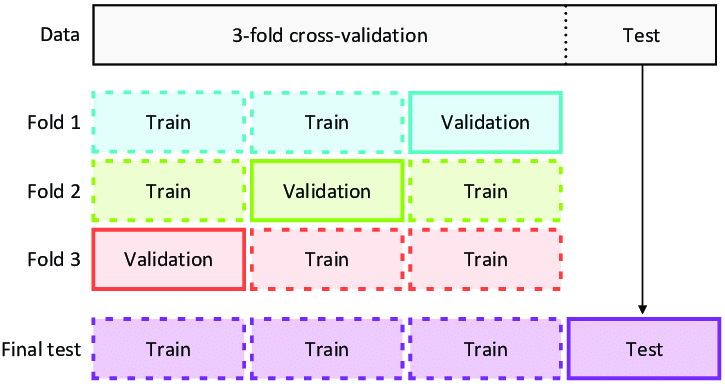

In [ ]:
# TODO
# tree number [1, 10, 50] (fold1)
# tree depth [1, 3, 5]
X_val_3 =  X[(X.shape[0]//3)*2:] #the 668-1002 data for val
y_val_3 =  y[(y.shape[0]//3)*2:]
X_train_3 = X[:(X.shape[0]//3)*2] #the 0-667 data for
y_train_3 = y[:(y.shape[0]//3)*2]


best_accuracy = 0
best_tree_number = 0
best_tree_depth = 0
for tree_number in [1, 10, 50]:
  for tree_depth in [1, 3, 5]:
    forest = RandomCRTforest(tree_number, tree_depth)
    forest.train(X_train_3, y_train_3)
    y_predict = forest.predict(X_val_3)
    accuracy = sum(y_predict==y_val_3)/y_predict.shape[0]
    print("For tree number {} and tree depth {} the accuracy is {}".format(tree_number, tree_depth, accuracy))
    if(accuracy > best_accuracy):
      best_accuracy = accuracy
      best_tree_number = tree_number
      best_tree_depth = tree_depth

forest = RandomCRTforest(best_tree_number, best_tree_depth)
forest.train(X, y)
y_test_predict = forest.predict(X_test)
test_accuracy = sum(y_test_predict==y_test)/y_test_predict.shape[0]
print("The test accuracy is", test_accuracy)

For tree number 1 and tree depth 1 the accuracy is 0.9940119760479041
For tree number 1 and tree depth 3 the accuracy is 0.9161676646706587
For tree number 1 and tree depth 5 the accuracy is 0.9910179640718563
For tree number 10 and tree depth 1 the accuracy is 0.9940119760479041
For tree number 10 and tree depth 3 the accuracy is 0.9940119760479041
For tree number 10 and tree depth 5 the accuracy is 0.9940119760479041
For tree number 50 and tree depth 1 the accuracy is 0.9910179640718563
For tree number 50 and tree depth 3 the accuracy is 0.9910179640718563
For tree number 50 and tree depth 5 the accuracy is 0.9910179640718563
The test accuracy is 0.9779559118236473


In [ ]:
# TODO
# tree number [1, 10, 50] (fold2)
# tree depth [1, 3, 5]
X_val_2 =  X[X.shape[0]//3:(X.shape[0]//3)*2] #the 335-668 data for val
y_val_2 =  y[y.shape[0]//3:(y.shape[0]//3)*2]
X_train_2 = np.vstack([X_val,X_val_3])
y_train_2 = np.hstack([y_val,y_val_3])

best_accuracy = 0
best_tree_number = 0
best_tree_depth = 0
for tree_number in [1, 10, 50]:
  for tree_depth in [1, 3, 5]:
    forest = RandomCRTforest(tree_number, tree_depth)
    forest.train(X_train_2, y_train_2)
    y_predict = forest.predict(X_val_2)
    accuracy = sum(y_predict==y_val_2)/y_predict.shape[0]
    print("For tree number {} and tree depth {} the accuracy is {}".format(tree_number, tree_depth, accuracy))
    if(accuracy > best_accuracy):
      best_accuracy = accuracy
      best_tree_number = tree_number
      best_tree_depth = tree_depth

forest = RandomCRTforest(best_tree_number, best_tree_depth)
forest.train(X, y)
y_test_predict = forest.predict(X_test)
#tree_num_2 = best_tree_number
#tree_depth_2 = best_tree_depth
test_accuracy = sum(y_test_predict==y_test)/y_test_predict.shape[0]
print("The test accuracy is", test_accuracy)

For tree number 1 and tree depth 1 the accuracy is 0.9850299401197605
For tree number 1 and tree depth 3 the accuracy is 0.9790419161676647
For tree number 1 and tree depth 5 the accuracy is 0.9850299401197605
For tree number 10 and tree depth 1 the accuracy is 0.9850299401197605
For tree number 10 and tree depth 3 the accuracy is 0.9820359281437125
For tree number 10 and tree depth 5 the accuracy is 0.9820359281437125
For tree number 50 and tree depth 1 the accuracy is 0.9820359281437125
For tree number 50 and tree depth 3 the accuracy is 0.9820359281437125
For tree number 50 and tree depth 5 the accuracy is 0.9820359281437125
The test accuracy is 0.9879759519038076


In [ ]:
# TODO
# tree number [1, 10, 50] (fold2)
# tree depth [1, 3, 5]

forest = RandomCRTforest(50,5)
forest.train(X, y)
y_test_predict = forest.predict(X_test)
test_accuracy_2 = sum(y_test_predict==y_test)/y_test_predict.shape[0]
print("The test accuracy is", test_accuracy_2)

The test accuracy is 0.9869739478957916


### **The CSV file**
The output_csv function is to output your answers to a standard format. (1) Please pass your best tree number, best tree depth and test accuracy from the holdout validation. You will receive 40% of the total score. (2) Please pass your best tree number, best tree depth and test accuracy from the 3-fold cross validation. You will receive 60% of the total score. 

Notice that if your format is different from us, you'll get zero points in this homework. 

In [ ]:
import csv
student_id = 'r10521804'
def output_csv(tree_num_1, tree_depth_1, test_accuracy_1, tree_num_2, tree_depth_2, test_accuracy_2):
  csv_file_name = student_id + '_p2.csv'
  with open(csv_file_name, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["tree_num_1", "tree_depth_1", "test_accuracy_1", "tree_num_2", "tree_depth_2", "test_accuracy_2"])
    writer.writerow([tree_num_1, tree_depth_1, round(test_accuracy_1,3), tree_num_2, tree_depth_2, round(test_accuracy_2, 3)])
    
# pass the numbers here
output_csv(tree_num_1,tree_depth_1,test_accuracy_1,50,5,test_accuracy_2)